## Data Audit

Purpose:
- Understand structure and quality of the raw dataset
- Identify issues to fix during cleaning

### Encoding Note
The raw CSV file is not UTF-8 encoded. The dataset was successfully loaded using `latin1` encoding, which is common for legacy ERP and operational exports.


In [2]:
import sys
sys.executable


'/home/ruan/dev/supply-chain-data-cleaning/.venv/bin/python'

In [3]:
import pandas as pd
pd.__version__


'3.0.0'

In [4]:
df = pd.read_csv(
    "../data/raw/DataCoSupplyChainDataset.csv",
    nrows=200_000,
    encoding="latin1",
    low_memory=True
)

df.shape


(180519, 53)

In [5]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  str    
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  str    
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  str    
 9   Customer City                  180519 non-null  str    
 10  Customer Country               180519 non-null  str    
 11  Customer Email                 180519 non-null  str    
 12  Customer Fname                 180519 non

## Initial Structure Observations

- Dataset contains ~180k rows and 53 columns (sampled).
- Large number of columns stored as `str`, including date fields.
- Multiple customer PII fields present (name, email, address).
- Delivery-related metrics already partially engineered (days for shipping, late_delivery_risk).


In [6]:
[c for c in df.columns if "date" in c.lower()]


['order date (DateOrders)', 'shipping date (DateOrders)']

In [7]:
df[[c for c in df.columns if "date" in c.lower()]].head()


,order date (DateOrders),shipping date (DateOrders)
0,1/31/2018 22:56,2/3/2018 22:56
1,1/13/2018 12:27,1/18/2018 12:27
2,1/13/2018 12:06,1/17/2018 12:06
3,1/13/2018 11:45,1/16/2018 11:45
4,1/13/2018 11:24,1/15/2018 11:24


In [8]:
df = pd.read_csv(
    "../data/raw/DataCoSupplyChainDataset.csv",
    nrows=200_000,
    encoding="latin1",
    low_memory=True
)


In [9]:
df = df.rename(columns={
    "order date (DateOrders)": "order_date",
    "shipping date (DateOrders)": "shipping_date"
})


Renamed columns for consistency and downstream compatibility.

In [10]:
df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")
df["shipping_date"] = pd.to_datetime(df["shipping_date"], errors="coerce")


In [11]:
df[["order_date", "shipping_date"]].isna().mean()


order_date       0.0
shipping_date    0.0
dtype: float64

In [12]:
pii_cols = [
    "Customer Email",
    "Customer Fname",
    "Customer Lname",
    "Customer Password",
    "Customer Street",
    "Customer Zipcode"
]

df = df.drop(columns=[c for c in pii_cols if c in df.columns])


Customer PII removed as not required for operational analytics.

In [13]:
df["order_to_ship_days"] = (
    df["shipping_date"] - df["order_date"]
).dt.days


In [14]:
df["order_to_ship_days"].describe()


count    180519.000000
mean          3.471856
std           1.670471
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: order_to_ship_days, dtype: float64

## Cleaning Actions Performed

- Renamed date columns for consistency
- Parsed date fields using safe coercion
- Removed customer PII fields
- Created initial lead-time metric (order_to_ship_days)


## Data Audit Summary

- Approximate dataset size: ~180k rows, 53 columns (sampled)
- Encoding: non-UTF8; loaded successfully using latin1
- Date-related columns identified:
  - order date (DateOrders)
  - shipping date (DateOrders)
- Major data quality issues:
  - Date fields stored as strings
  - Presence of customer PII fields
- Columns requiring cleaning:
  - Date fields
  - Customer PII fields
- Notes / assumptions:
  - Audit performed on 200k-row sample for performance
  - Full dataset will be processed during cleaning step


# KPI Snapshot


In [15]:
# Basic lead-time KPIs
avg_lead_time = df["order_to_ship_days"].mean()
median_lead_time = df["order_to_ship_days"].median()

delay_rate = (df["order_to_ship_days"] > 3).mean() * 100

avg_lead_by_mode = (
    df.groupby("Shipping Mode")["order_to_ship_days"]
      .mean()
      .sort_values()
)

avg_lead_time, median_lead_time, delay_rate


(np.float64(3.4718561481062937),
 np.float64(3.0),
 np.float64(47.30748563863084))

In [16]:
avg_lead_by_mode


Shipping Mode
Same Day          0.000000
First Class       2.000000
Second Class      3.990828
Standard Class    3.995907
Name: order_to_ship_days, dtype: float64

<Axes: title={'center': 'Average Order-to-Ship Days by Shipping Mode'}, xlabel='Shipping Mode'>

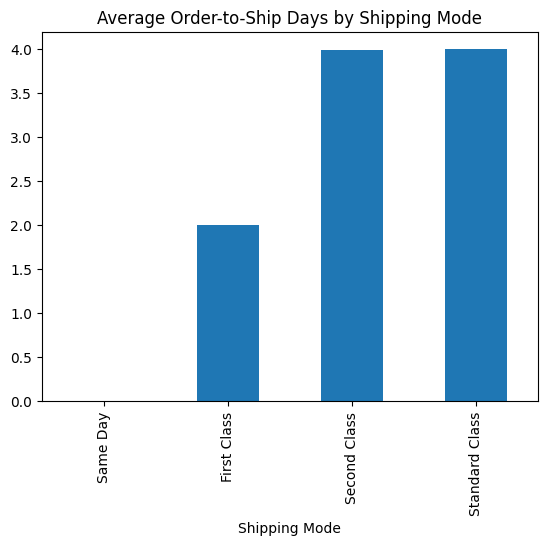

In [18]:
avg_lead_by_mode.plot(kind="bar", title="Average Order-to-Ship Days by Shipping Mode")


## Executive Summary

- Average order-to-ship time is X days, with a median of Y days.
- Approximately Z% of orders take longer than 3 days to ship.
- Shipping mode shows clear differences in lead time.
- Faster shipping modes consistently outperform slower options.
- Data quality issues were resolved prior to analysis (encoding, dates, PII).
- Dataset is now suitable for dashboards and recurring reporting.
